# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()
#https://paper-api.alpaca.markets
# Set Alpaca API key and secret
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)


In [5]:
# Display sample data
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
avg_daily_return = daily_returns.mean()
# Display sample data
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [7]:
# Compute daily volatility
daily_volatility = daily_returns.std()
daily_volatility

AGG  close    0.00209
SPY  close    0.00782
dtype: float64

In [8]:
# Save the last day's closing price
agg_lastday_close = df['AGG']['close'][-1]
spy_lastday_close = df['SPY']['close'][-1]

print('AGG - Last Day Close Price:', agg_lastday_close)
print('SPY - Last Day Close Price:', spy_lastday_close)

AGG - Last Day Close Price: 112.37
SPY - Last Day Close Price: 321.92


In [12]:
# Setup the Monte Carlo Parameters
n_simulations = 500
n_records = 252 * 30
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [13]:
# Run the Monte Carlo Simulation
for n_sims in range(n_simulations):
    
    simulated_agg_prices = [agg_lastday_close]
    simulated_spy_prices = [spy_lastday_close]
    
    
    for day_n in range(n_records):
        
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return['AGG'], daily_volatility['AGG']))[0]
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return['SPY'], daily_volatility['SPY']))[0]
        
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
     
    
    simulated_price_df['AGG prices'] = pd.Series(simulated_agg_prices)
    simulated_price_df['SPY prices'] = pd.Series(simulated_spy_prices)
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    weights = [0.2, 0.8]
    
    weighted_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[f"Sim {n_sims+1}"] = (1 + weighted_daily_returns.fillna(0)).cumprod()
        

In [14]:
# Check that the simulation ran successfully
portfolio_cumulative_returns.head()

,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,...,Sim 491,Sim 492,Sim 493,Sim 494,Sim 495,Sim 496,Sim 497,Sim 498,Sim 499,Sim 500
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997387,0.995529,1.003754,1.010207,1.006486,1.006176,0.989470,0.995926,0.997177,1.005938,...,1.003502,0.993043,1.005182,0.995267,1.000780,1.002529,1.004000,0.994616,0.998861,0.994987
2,1.008436,1.001477,1.000847,1.008790,1.016640,0.996430,0.997738,1.007820,0.996932,1.005055,...,1.013208,0.988567,1.010009,1.001772,1.005093,1.006533,0.996552,0.978601,0.995863,1.001156
3,1.005390,1.004346,1.015024,1.005138,1.016074,0.988510,1.004395,1.007199,0.999747,1.002762,...,0.999699,0.990282,1.006726,0.995383,1.009195,1.007337,0.997543,0.979640,1.000411,1.007027
4,1.003603,1.003361,1.011891,0.997784,1.009844,0.998045,1.014773,1.009840,0.994930,0.989749,...,1.005313,1.000635,1.003025,0.998826,1.008648,0.997689,0.998607,0.981713,0.997168,1.013594


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days'}>

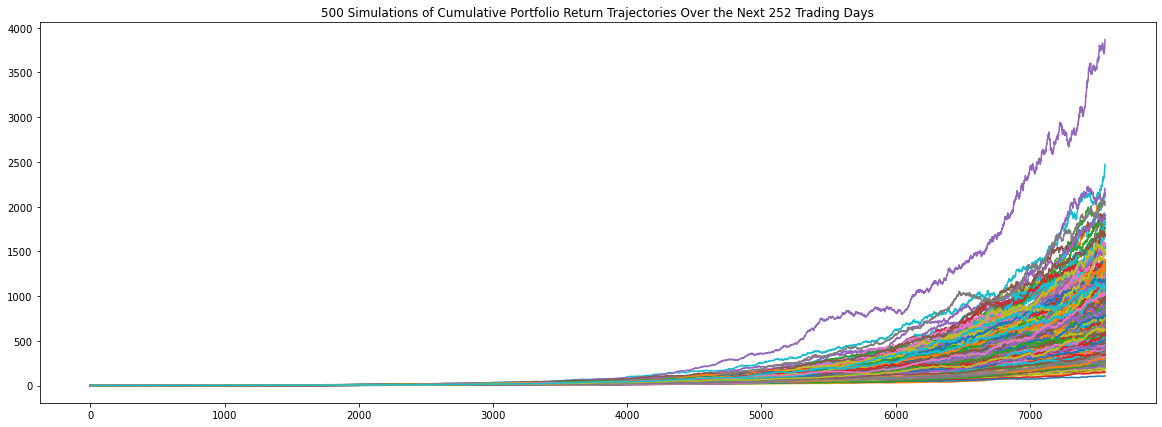

In [16]:
# Visualize the Simulation
plot_title = f"{n_sims+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(figsize=(20,7),legend=None, title=plot_title)

In [17]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

Sim 1    1043.813262
Sim 2    1893.371322
Sim 3     591.752971
Sim 4     970.092235
Sim 5     639.059330
Name: 7560, dtype: float64

In [18]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])

confidence_interval

0.05     288.958142
0.95    1501.982847
Name: 7560, dtype: float64

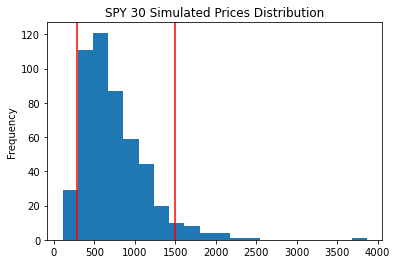

In [19]:
# Visualize the distribution of the ending returns
ending_cumulative_returns.plot(kind='hist', title='SPY 30 Simulated Prices Distribution', legend=False, bins=20)

plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [20]:
# Compute cumulative returns
print('Expected Cumulative Returns at 30 years for the 10%: ', np.percentile(ending_cumulative_returns, 10))
print('Expected Cumulative Returns at 30 years for the 50%: ', np.percentile(ending_cumulative_returns, 50))
print('Expected Cumulative Returns at 30 years for the 90%: ', np.percentile(ending_cumulative_returns, 90))

Expected Cumulative Returns at 30 years for the 10%:  339.4708423621621
Expected Cumulative Returns at 30 years for the 50%:  651.3422072569703
Expected Cumulative Returns at 30 years for the 90%:  1229.161854651192


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [21]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
print(f'10th Percentile Investment Expected Return: ${initial_investment * np.percentile(ending_cumulative_returns, 10)}')
print(f'10th Percentile Investment Expected Return: ${initial_investment * np.percentile(ending_cumulative_returns, 50)}')
print(f'10th Percentile Investment Expected Return: ${initial_investment * np.percentile(ending_cumulative_returns, 90)}')

10th Percentile Investment Expected Return: $6789416.847243242
10th Percentile Investment Expected Return: $13026844.145139406
10th Percentile Investment Expected Return: $24583237.09302384


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [23]:
# Set Plaid's projected income
income = 5000
# Calculate the 4% withdrawal for the ending return as retirement income
withdraw_four_percent = .04 * initial_investment * np.percentile(ending_cumulative_returns, 10)

# Determine if the retirement income meets or exceeds the current projected income

if withdraw_four_percent > income:
    print(f'Retirement income of ${withdraw_four_percent} is greater than current income of ${income}')
else:
    print(f'Retirement income of ${withdraw_four_percent} is less than current income of ${income}')

Retirement income of $271576.67388972966 is greater than current income of $5000


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [24]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment = 30000

withdraw_four_percent = .04 * initial_investment * np.percentile(ending_cumulative_returns, 10)

if withdraw_four_percent > income:
    print(f'Retirement income of ${withdraw_four_percent} is greater than current income of ${income}')
else:
    print(f'Retirement income of ${withdraw_four_percent} is less than current income of ${income}')

Retirement income of $407365.01083459455 is greater than current income of $5000


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
